In [1]:
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import dataset_processing
import torch.optim as optim
from torch.autograd import Variable
import torch
from dataset_processing import DatasetProcessing

DATA_PATH = 'data'
TRAIN_DATA = 'train_img'
TEST_DATA = 'test_img'
TRAIN_IMG_FILE = 'train_img.txt'
TEST_IMG_FILE = 'test_img.txt'
TRAIN_LABEL_FILE = 'train_label.txt'
TEST_LABEL_FILE = 'test_label.txt'

/home/kaidashova/anaconda3/envs/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NLABELS = 5

batch_size = 4

transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()])

In [ ]:
print(TRAIN_DATA)
dset_train = dataset_processing.DatasetProcessing(
    DATA_PATH, TRAIN_DATA, TRAIN_IMG_FILE, TRAIN_LABEL_FILE, transformations)

train_img


In [4]:
dset_test = dataset_processing.DatasetProcessing(
    DATA_PATH, TEST_DATA, TEST_IMG_FILE, TEST_LABEL_FILE, transformations)

In [5]:
train_loader = DataLoader(dset_train,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4
                         )

In [6]:
test_loader = DataLoader(dset_test,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=4
                         )

In [7]:
class MultiLabelNN(nn.Module):
    def __init__(self, nlabel):
        super(MultiLabelNN, self).__init__()
        self.nlabel = nlabel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(179776,1024)
        self.fc2 = nn.Linear(1024, nlabel)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        # x = self.pool(x)
        x = x.view(-1, 179776)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [8]:
use_gpu = torch.cuda.is_available()

model = MultiLabelNN(NLABELS)
if use_gpu:
    model = model.cuda()

In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.0001)
criterion = nn.MultiLabelMarginLoss()

In [10]:
epochs = 3
for epoch in range(epochs):
    ### training phase
    total_training_loss = 0.0
    # total = 0.0
    for iter, traindata in enumerate(train_loader, 0):
        train_inputs, train_labels = traindata
        if use_gpu:
            train_inputs, train_labels = Variable(train_inputs.cuda()), Variable(train_labels.cuda())
        else: train_inputs, train_labels = Variable(train_inputs), Variable(train_labels)

        optimizer.zero_grad()

        train_outputs = model(train_inputs)
        loss = criterion(train_outputs, train_labels)
        loss.backward()
        optimizer.step()

        # total += train_labels.size(0)
        total_training_loss += loss.data
        print('Training Phase: Epoch: [%2d][%2d/%2d]\tIteration Loss: %.3f' %
              (iter, epoch, epochs, loss.data / train_labels.size(0)))
    ### testing phase
    for iter, testdata in enumerate(test_loader, 0):
        test_inputs, test_labels = testdata
        if use_gpu:
            test_inputs, test_labels = Variable(test_inputs.cuda()), Variable(test_labels.cuda())
        else: test_inputs, test_labels = Variable(test_inputs), Variable(test_labels)

        test_outputs = model(test_inputs)
        test_loss = criterion(test_outputs, test_labels)
        print('Testing Phase: Epoch: [%2d][%2d/%2d]\tIteration Loss: %.3f' %
              (iter, epoch, epochs, test_loss.data / test_labels.size(0)))

Training Phase: Epoch: [ 0][ 0/ 3]	Iteration Loss: 0.776
Training Phase: Epoch: [ 1][ 0/ 3]	Iteration Loss: 0.767
Training Phase: Epoch: [ 2][ 0/ 3]	Iteration Loss: 0.761
Training Phase: Epoch: [ 3][ 0/ 3]	Iteration Loss: 0.752
Training Phase: Epoch: [ 4][ 0/ 3]	Iteration Loss: 0.748
Training Phase: Epoch: [ 5][ 0/ 3]	Iteration Loss: 0.736
Training Phase: Epoch: [ 6][ 0/ 3]	Iteration Loss: 0.730
Training Phase: Epoch: [ 7][ 0/ 3]	Iteration Loss: 0.719
Training Phase: Epoch: [ 8][ 0/ 3]	Iteration Loss: 0.716
Training Phase: Epoch: [ 9][ 0/ 3]	Iteration Loss: 0.705
Training Phase: Epoch: [10][ 0/ 3]	Iteration Loss: 0.700
Training Phase: Epoch: [11][ 0/ 3]	Iteration Loss: 0.694
Training Phase: Epoch: [12][ 0/ 3]	Iteration Loss: 0.679
Training Phase: Epoch: [13][ 0/ 3]	Iteration Loss: 0.664
Training Phase: Epoch: [14][ 0/ 3]	Iteration Loss: 0.664
Training Phase: Epoch: [15][ 0/ 3]	Iteration Loss: 0.666
Training Phase: Epoch: [16][ 0/ 3]	Iteration Loss: 0.658
Training Phase: Epoch: [17][ 0/

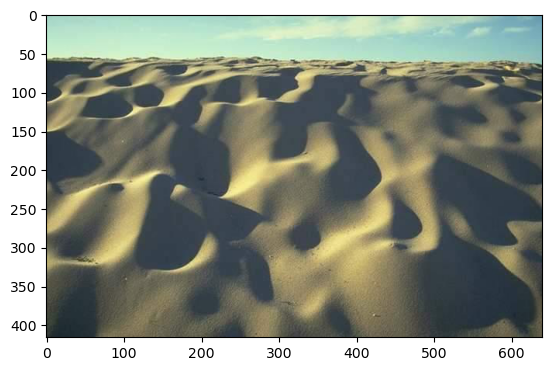

In [11]:
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

image = Image.open('./data/test_img/2.jpg')  # Load the image
input_tensor = transform(image).unsqueeze(0)
plt.imshow(image)

In [12]:
torch.save(model.state_dict(), "model.pth")

In [13]:
model = MultiLabelNN(NLABELS)
model.load_state_dict(torch.load("model.pth"))
model.eval()

MultiLabelNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=179776, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=5, bias=True)
)

In [14]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard ImageNet normalization
])

image = Image.open('./data/test_img/1651.jpg')  # Load the image
input_tensor = transform(image).unsqueeze(0)
input_tensor.cuda()

tensor([[[[-2.0494, -2.0152, -1.9980,  ..., -2.0494, -2.0665, -2.0665],
          [-2.0152, -2.0152, -1.9980,  ..., -2.0494, -2.0665, -2.0665],
          [-1.9980, -1.9980, -1.9980,  ..., -2.0494, -2.0665, -2.0665],
          ...,
          [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
          [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837],
          [-2.0837, -2.0837, -2.0837,  ..., -2.0837, -2.0837, -2.0837]],

         [[-1.5105, -1.4755, -1.4580,  ..., -1.4755, -1.4930, -1.4930],
          [-1.4755, -1.4755, -1.4580,  ..., -1.4755, -1.4930, -1.4930],
          [-1.4580, -1.4580, -1.4580,  ..., -1.4755, -1.4930, -1.4930],
          ...,
          [-2.0007, -2.0007, -2.0007,  ..., -2.0007, -2.0007, -2.0007],
          [-2.0007, -2.0007, -2.0007,  ..., -2.0007, -2.0007, -2.0007],
          [-2.0007, -2.0007, -2.0007,  ..., -2.0007, -2.0007, -2.0007]],

         [[-0.2881, -0.2532, -0.2358,  ..., -0.1487, -0.1661, -0.1661],
          [-0.2532, -0.2532, -

In [15]:
predicted = model(input_tensor)
threshold = 0.5  # Set threshold for attribute presence
predicted_labels = (predicted > threshold).int()

print(f"Predicted class index: {predicted}")

Predicted class index: tensor([[ 0.7779,  0.6226, -0.4143, -0.4113, -0.5146]],
       grad_fn=<AddmmBackward0>)


In [16]:
def predict(model, dataloader, use_gpu):
    model.eval()  # Set model to evaluation mode
    predictions = []
    device = torch.device("cuda" if use_gpu else "cpu")  # Choose device
    model.to(device)  # Move model to the device
    
    with torch.no_grad():  # Disable gradient computation for inference
        for inputs, _ in dataloader:
            inputs = inputs.to(device)  # Move inputs to the same device
            outputs = model(inputs)
            predicted_labels = torch.sigmoid(outputs)   # Apply sigmoid for multilabel
            predictions.append(predicted_labels.cpu())  # Move predictions to CPU for processing
    return torch.cat(predictions, dim=0)



In [17]:
predictions = predict(model, test_loader, use_gpu)
print(predictions)

tensor([[0.6841, 0.6438, 0.3876, 0.3929, 0.3888],
        [0.7760, 0.7277, 0.3237, 0.3253, 0.3193],
        [0.7798, 0.7347, 0.3177, 0.3235, 0.3158],
        ...,
        [0.7321, 0.6887, 0.3553, 0.3586, 0.3544],
        [0.8142, 0.7653, 0.2924, 0.2970, 0.2890],
        [0.7442, 0.6979, 0.3451, 0.3506, 0.3440]])
